<a href="https://colab.research.google.com/github/BLOOMFLARK/NN_noise_classification/blob/master/CPNTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn.functional as F
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models, datasets

import random

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

net = None

In [0]:
class CPNTR(torch.nn.Module):
    def __init__(self, num_filters: list, filters_sizes: list):
        super(CPNTR, self).__init__()
        self.params = {
            'num_filters': num_filters,
            'filters_sizes': filters_sizes,
        }
        self.W_1 = None
        self.W_2 = None

        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.act1 = torch.nn.ReLU()
        self.fc = torch.nn.Linear(968, 2, bias=True)

    def forward(self, x):
        x = F.conv2d(x, self.W_1)
        x = self.act1(x)
        x = self.pool1(x)
        N1, C1, H1, W1 = x.shape

        x = F.conv2d(x, self.W_2)
        x = self.act1(x)
        x = self.pool1(x)
        N, C, H, W = x.shape

        # сюда можно еще добавить сверточных слоев и FC
        x_flat = x.view(N, C * H * W)

        x_flat = self.fc(x_flat)
        return x_flat
                   
    def _extract_image_patches(self, imgs, filter_size, step=1, remove_mean=True):
        """ Функция, которая достает патчи размера filter_size x filter_size вокруг каждого пиксела изображения
            Args:
                imgs (torch.FloatTensor): изображения размера (N, C, H, W)
                filter_size (int): размер фильтра (k в статье)
                step (int): шаг для метода unfold, который извлекает патчи
                remove_mean (bool): флаг центрировать патчи или нет
            Return:
                X (torch.FloatTensor): Матрица X из статьи размера (k**2, N*H*W)

        """
        # imgs.shape = (N, C, H, W) -> (N, 1, H, W) 
        # так должно быть, но сюда могут прийти не grayscale изображения первого шага, а со второго
        # на котором применено L1 фильтров -> L1 каналов

        N, n_channels, H, W = imgs.shape
        stride = 1
        
        if n_channels > 1:
            # изображение вида (N, C, H, W) - N C-канальных изображений
            # приводим к виду (N*C, 1, H, W) - N*C одно-канальных изображений
            imgs = imgs.view(-1, 1, H, W)
        print(f'images shape: {imgs.shape}')
            
        k = filter_size
        pad = tuple([k // 2 for i in range(4)]) # (k//2 , k//2, k//2, k//2)
        # делаем пад для изображений со всех 4 сторон, чтобы центром патча был каждый пиксел изображения (без пада)
        imgs_padded = torch.nn.functional.pad(imgs, pad=pad, mode='constant', value=0)

        patches = (imgs_padded.unfold(1 + 1, k, step).unfold(1 + 2, k, step)) # (N, C, H, W, k, k)
        patches = patches.flatten(1 + 1, 1 + 2).flatten(-2) # (N, 1, H*W, k^2)
        patches = patches.squeeze(1) # (N, H*W, k^2)

        print(f'patches_shape: {patches.shape} ')
        print(f'should be patches shape: {(imgs.shape[0], H*W, k**2)}')
        
        if remove_mean:
            patches -= patches.mean(dim=2, keepdim=True) # последнее измерение - патч
        
        print(f'filter_size: {k}')
        X = patches.view(-1, k**2) # (N*H*W, k^2)

        return X.permute(1, 0) # (k^2, N*H*W)
    
    def _convolve(self, imgs, filter_bank):
        """ Функция, которая производит свертку изображений с матрицей весов
            Args:
                imgs (torch.FloatTensor): изображения размера (N, C, H, W)
                filter_bank (torch.FloatTensor): размер фильтра (k в статье)
            Return:
                output (torch.FloatTensor): Результат свертки imgs с матрицой весов filter_bank

        """
        weight = filter_bank
        output = F.conv2d(imgs, weight, padding=1)
        return output
    
    def _first_stage(self, imgs, train):
        """ Первый шаг в PCANET: получения первых фильтров или же свертка изображений с этими фильтрами.
            Args:
                imgs (torch.FloatTensor): изображения размера (N, C, H, W)
                train (bool): режим обучения(получения фильтров) или предикта.
            Return:
                I (torch.FloatTensor): Результат свертки imgs с матрицой весов filter_bank

        """
        # (train_size, 1, H, W) - grayscale
        assert imgs.dim() == 4 and imgs.nelement() > 0

        print('model first stage...')

        if train:
            # достаем все патчи из всех N изображений
            filter_size1 = self.params['filters_sizes'][0]
            X = self._extract_image_patches(
                imgs, filter_size1)
            
            n_filters = self.params['num_filters'][0]
            
            eigenvectors = self.get_pca_eigenvectors(X, n_components=n_filters)
            self.W_1 = torch.FloatTensor(eigenvectors).view(n_filters, 1, filter_size1, filter_size1)
         
        I = self._convolve(imgs, self.W_1)  # (N, 1, H, W) * (L1, k1, k1) -> (N, L1, H', W')
        return I
    
    @staticmethod
    def conv_output_size(w, filter_size, padding=1, stride=1):
        return int((w - filter_size + 2 * padding) / stride + 1)
    
    def get_pca_eigenvectors(self, X, n_components):
        """ Получение собственных векторов
            Args:
                n_components: число главных компонент == числу фильтров на 1 или 2 стадии
            Return:
                I (torch.FloatTensor): Результат свертки imgs с матрицой весов filter_bank

        """
        ipca = IncrementalPCA(n_components=n_components, batch_size=100)

        print('pca fitting ...')
        ipca.fit(X @ X.t())

        eigenvectors = ipca.components_
        print(f'eigenvectors shape: {eigenvectors.shape}')

        return eigenvectors
        
    def _second_stage(self, I, train):
        """ Второй шаг в PCANet: получения вторых фильтров или же свертка изображений с этими фильтрами.
            Args:
                I (torch.FloatTensor): изображения размера (N, C, H, W)
                train (bool): режим обучения(получения фильтров) или предикта.
            Return:
                II (torch.FloatTensor): Результат свертки I с матрицой весов W_2

        """
        print('PCANet second stage...')
        # I: (N, L1, H, W)
        if train:
            N, L1, H, W = I.shape
            filter_size2 = self.params['filters_sizes'][1]
            n_filters2 = self.params['num_filters'][1]
            n_filters1 = self.params['num_filters'][0]
            
            H_new = self.conv_output_size(I.shape[2], filter_size2)
            W_new = self.conv_output_size(I.shape[3], filter_size2)
            
            X = self._extract_image_patches(I, filter_size2)

            print(f'X_SHAPE: {X.shape}')

            eigenvectors = self.get_pca_eigenvectors(X, n_components=n_filters2)
            
            W_2 = torch.FloatTensor(eigenvectors).view(n_filters2, 1, filter_size2, filter_size2) # (L2, 1, k2, k2)
            self.W_2 = W_2.repeat(1, n_filters1, 1, 1) # (L2, L1, k2, k2) - повторяет L1 раз для конкретного l из L2

        return self._convolve(I, self.W_2)
    
    def make_filters(self, images, to_fit=True):
        # Создаем фильтры
        # images: (N, 1, H, W)
        I = self._first_stage(images, train=to_fit)
        print(f"I: {I.shape}")

        II = self._second_stage(I, train=to_fit)
        print(f"II: {II.shape}")

    def fit(self, loss, optimizer, device, train_tensors, train_dataloader, val_dataloader, num_epochs=100):
        self.val_loss = np.zeros(num_epochs)
        self.train_loss = np.zeros(num_epochs)

        self.val_acc = np.zeros(num_epochs)
        self.train_acc = np.zeros(num_epochs)

        if self.W_1 is None or self.W_2 is None:
            self.make_filters(train_tensors)
        
        self.W_1 = self.W_1.to(device)
        self.W_2 = self.W_2.to(device)

        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    #data = train_data
                    dataloader = train_dataloader
                    self.train()  # training mode
                    history_acc = self.train_acc
                    history_loss = self.train_loss
                else:
                    #data = test_data
                    dataloader = val_dataloader
                    self.eval()   # evaluate mode (dropout + bn)
                    history_acc = self.val_acc
                    history_loss = self.val_loss

                running_loss = 0.
                running_acc = 0.

                # Iterate over data.
                for inputs, labels in dataloader:
                    # перевод в grayscale
                    inputs = inputs.mean(axis=1).unsqueeze(1)
                    
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # forward and backward
                    with torch.set_grad_enabled(phase=='train'):
                        preds = self(inputs)
                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss_value.cpu().item()
                    running_acc += (preds_class.cpu() == labels.cpu().data).float().mean()
            
                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)

                history_acc[epoch] = epoch_acc
                history_loss[epoch] = epoch_loss

                print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc), flush=True)
    
    def plot_loss(self):
        num_epochs = self.train_loss.shape[0]

        plt.plot(range(num_epochs), self.train_loss, self.val_loss)
        plt.legend(['train', 'val'])
        plt.xlabel('epoch')
        plt.ylabel('cross entropy loss')
        plt.title('loss')

        plt.show()

    def plot_acc(self):
        num_epochs = self.train_acc.shape[0]

        plt.plot(range(num_epochs), self.train_acc, self.val_acc)
        plt.legend(['train', 'val'])
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('accuracy')

        plt.show()

In [11]:
net = CPNTR([8, 8], [7, 7]) if net is None else net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)

batch_size = 100
lr = 1e-4

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#optimizer = torch.optim.SGD(net.parameters(), lr=lr)

cuda:0


## Теперь поработаем с нашими данными

In [0]:
data_root = 'drive/My Drive/dl_noise_classification/data/'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'
class_names = ['awgn', 'bayer']

train_dir = os.path.join(data_root, train_dir)
val_dir = os.path.join(data_root, val_dir)
test_dir = os.path.join(data_root, test_dir)

In [6]:
# TODO: добавить трансформации для трейна, чтобы не было overfitting
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(train_dir, train_transforms)
val_dataset = datasets.ImageFolder(val_dir, val_transforms)

train_size = len(train_dataset)
val_size = len(val_dataset)

#all_train = torch.utils.data.DataLoader(
#    train_dataset, batch_size=train_size, shuffle=False, num_workers=batch_size)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

#all_val = torch.utils.data.DataLoader(
#    val_dataset, batch_size=train_size, shuffle=False, num_workers=val_size)

print("TRAIN_SIZE: {}\n VAL_SIZE: {}\n".format(train_size, val_size))


TRAIN_SIZE: 1200
 VAL_SIZE: 400



## Загружаем train картинки (тензоры) все и сразу. Нужны для фильтров

In [7]:
%%time
train_tensors, _ = torch.load('drive/My Drive/dl_noise_classification/data/tensor_images64x64.pth')
# val_data = torch.load('drive/My Drive/dl_noise_classification/data/tensor_images64x64_val.pth')

CPU times: user 6.58 ms, sys: 19.4 ms, total: 26 ms
Wall time: 44.6 ms


In [12]:
net.fit(loss,
        optimizer,
        device,
        train_tensors=train_tensors,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        num_epochs=100)

Epoch 0/99:
train Loss: 0.8399 Acc: 0.5267

val Loss: 1.3020 Acc: 0.4450

Epoch 1/99:
train Loss: 0.7954 Acc: 0.5492

val Loss: 1.2894 Acc: 0.4375

Epoch 2/99:
train Loss: 0.7850 Acc: 0.5300

val Loss: 1.2609 Acc: 0.4375

Epoch 3/99:
train Loss: 0.7670 Acc: 0.5317

val Loss: 1.2577 Acc: 0.4425

Epoch 4/99:
train Loss: 0.7597 Acc: 0.5233

val Loss: 1.2543 Acc: 0.4425

Epoch 5/99:
train Loss: 0.7477 Acc: 0.5242

val Loss: 1.2553 Acc: 0.4400

Epoch 6/99:
train Loss: 0.7516 Acc: 0.5183

val Loss: 1.2409 Acc: 0.4425

Epoch 7/99:
train Loss: 0.7526 Acc: 0.5108

val Loss: 1.2224 Acc: 0.4475

Epoch 8/99:
train Loss: 0.7276 Acc: 0.5383

val Loss: 1.2111 Acc: 0.4500

Epoch 9/99:
train Loss: 0.7352 Acc: 0.5342

val Loss: 1.2264 Acc: 0.4500

Epoch 10/99:
train Loss: 0.7127 Acc: 0.5467

val Loss: 1.2235 Acc: 0.4475

Epoch 11/99:
train Loss: 0.7137 Acc: 0.5517

val Loss: 1.1855 Acc: 0.4525

Epoch 12/99:
train Loss: 0.7181 Acc: 0.5192

val Loss: 1.2023 Acc: 0.4550

Epoch 13/99:
train Loss: 0.7168 Acc

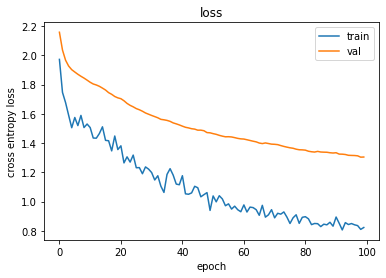

In [9]:
net.plot_loss()

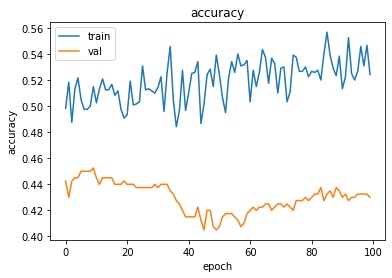

In [10]:
net.plot_acc()

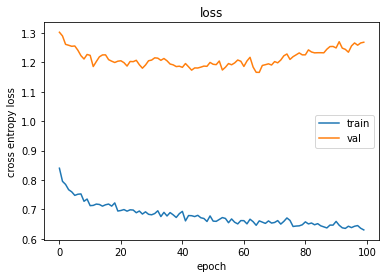

In [13]:
net.plot_loss()

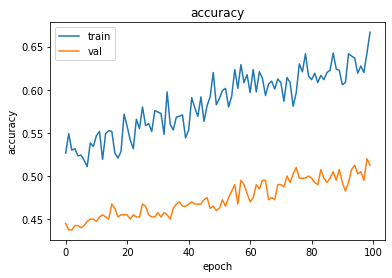

In [14]:
net.plot_acc()

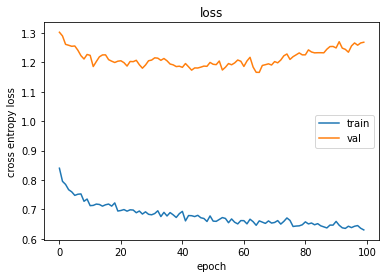

In [15]:
net.plot_loss()